In [1]:
# Use modules from parent directory
import os
import sys
import tifffile as tiff
import numpy as np
from PIL import Image
Image.MAX_IMAGE_PIXELS = 1000000000   
import matplotlib.pyplot as plt

sys.path.insert(0, '../')
%load_ext autoreload
%autoreload 2
from srcv2_2.models.params import get_params
from srcv2_2.models.Unet import Unet, UnetV2
from srcv2_2.visualization.make_image_files import visualize_test_data, __visualize_landsat8_tile__
from srcv2_2.visualization.visualization_utils import get_predicted_thumbnails 
from srcv2_2.utils import get_model_name, predict_img_mod

import tensorflow as tf

2024-03-20 17:15:00.515840: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-20 17:15:00.535136: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-20 17:15:00.535151: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-20 17:15:00.535694: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-20 17:15:00.539245: I tensorflow/core/platform/cpu_feature_guar

## Load KERAS Model

In [33]:
params = get_params('U-net', 'MODIS') # still trained and tested on L8
params.cls = ['cloud', 'thin'] # clear, cloud, shadow, snow, water
params.project_path = "/home/mxh/RS-Net/"
activation_func='relu'
params.learning_rate =1e-3
params.epochs = 5
params.threshold = 0.5
params.dropout = 0
params.L2reg = 0
params.decay = 0
params.num_gpus = 1
params.overlap=40
params.modelID = "Test_predict_v2"
params.norm_threshold = 3500

#tile = 'all'  # Name of one tile or 'all'
#tile = 'L2A_T32UNF_20170803T103019' 

In [2]:
params = get_params('U-net', 'MODIS') # still trained and tested on L8
params.cls = ['cloud', 'thin'] # clear, cloud, shadow, snow, water
params.project_path = "/home/mxh/RS-Net/"
activation_func='relu'
params.learning_rate =1e-3
params.epochs = 5
params.threshold = 0.5
params.dropout = 0
params.L2reg = 0
params.decay = 0
params.num_gpus = 1
params.overlap=10
params.modelID = "Test_predict_v2_overlap10"
params.norm_threshold = 3500

#tile = 'all'  # Name of one tile or 'all'
#tile = 'L2A_T32UNF_20170803T103019' 

In [4]:
params = get_params('U-net', 'Landsat8')
params.cls = ['cloud', 'thin'] # clear, cloud, shadow, snow, water
params.project_path = "/home/mxh/RS-Net/"
activation_func='relu'
params.learning_rate =1e-3
params.epochs = 5
params.threshold = 0.5
params.dropout = 0
params.L2reg = 0
params.decay = 0
params.num_gpus = 1
params.modelID = "Test_Local"
params.norm_threshold = 3500

#tile = 'all'  # Name of one tile or 'all'
#tile = 'L2A_T32UNF_20170803T103019' 

In [34]:
local_loaded_model = tf.keras.saving.load_model(f"../models/Unet/{get_model_name(params)}.keras")
# weights and funcs will automatically be loaded

unet_loaded_local_model = UnetV2(params, model=local_loaded_model)

In [35]:
# get params
print(unet_loaded_local_model.params.__dict__)

{'modelNick': 'Unet-MOD09GA', 'modelID': 'Test_predict_v2', 'num_gpus': 1, 'optimizer': 'Adam', 'loss_func': 'binary_crossentropy', 'activation_func': 'elu', 'initialization': 'glorot_uniform', 'use_batch_norm': True, 'dropout_on_last_layer_only': True, 'early_stopping': False, 'reduce_lr': False, 'save_best_only': False, 'use_ensemble_learning': False, 'ensemble_method': 'Bagging', 'learning_rate': 0.001, 'dropout': 0, 'L1reg': 0.0, 'L2reg': 0, 'L1L2reg': 0.0, 'decay': 0, 'batch_norm_momentum': 0.7, 'threshold': 0.5, 'patch_size': 256, 'overlap': 40, 'overlap_train_set': 0, 'batch_size': 40, 'steps_per_epoch': None, 'epochs': 5, 'norm_method': 'enhance_contrast', 'norm_threshold': 3500, 'cls': ['cloud', 'thin'], 'collapse_cls': True, 'affine_transformation': True, 'brightness_augmentation': False, 'bands': [1, 2, 3, 4, 5, 6, 7], 'project_path': '/home/mxh/RS-Net/', 'toa_path': 'data/processed/Biome_TOA/', 'data_path': 'data/raw/Biome_dataset/', 'satellite': 'MODIS', 'dataset': 'MOD09G

In [4]:
tf.keras.saving.get_custom_objects()

{'Custom>Adadelta': keras.src.optimizers.adadelta.Adadelta,
 'Custom>Adafactor': keras.src.optimizers.adafactor.Adafactor,
 'Custom>Adagrad': keras.src.optimizers.adagrad.Adagrad,
 'Custom>Adam': keras.src.optimizers.adam.Adam,
 'Custom>Adamax': keras.src.optimizers.adamax.Adamax,
 'Custom>AdamW': keras.src.optimizers.adamw.AdamW,
 'Custom>Ftrl': keras.src.optimizers.ftrl.Ftrl,
 'Custom>Lion': keras.src.optimizers.lion.Lion,
 'Custom>Nadam': keras.src.optimizers.nadam.Nadam,
 'Custom>RMSprop': keras.src.optimizers.rmsprop.RMSprop,
 'Custom>SGD': keras.src.optimizers.sgd.SGD,
 'Custom>CustomScaleLayer': keras.src.applications.inception_resnet_v2.CustomScaleLayer,
 'Custom>SharpnessAwareMinimization': keras.src.models.sharpness_aware_minimization.SharpnessAwareMinimization,
 'Custom>get_params': <function srcv2_2.models.params.get_params(model, satellite)>,
 'Custom>jaccard_coef': <function srcv2_2.models.model_utils.jaccard_coef(y_true, y_pred)>,
 'Custom>jaccard_coef_thresholded': <fun

In [7]:
from osgeo import gdal
import tifffile as tiff
import matplotlib.pyplot as plt
import numpy as np

In [8]:
day1 = "MOD09GA.A2023335.h18v04.061.2023340033530"
modis_tower_path="/media/mxh/Volume/SAT-DATA/MODIS_MOD09GA_GERITAFRA_31day_DEC2023/"


In [ ]:


img_tiff_toa  = tiff.imread(modis_tower_path+day1+"_TOA_256.tiff")
img_gdal_toa = gdal.Open(modis_tower_path+day1+"_TOA_256.tiff").ReadAsArray()

img_gdal_merged = gdal.Open(modis_tower_path+day1+"_merged_256.tif")
img_tiff_merged  = tiff.imread(modis_tower_path+day1+"_merged_256.tif")

In [7]:
resized_img_tiff_toa = tf.image.resize(img_tiff_toa, (256,256))
resized_img_gdal_merged = tf.image.resize(img_gdal_merged.ReadAsArray(), (256,256))
resized_img_tiff_merged = tf.image.resize(img_tiff_merged, (256,256))

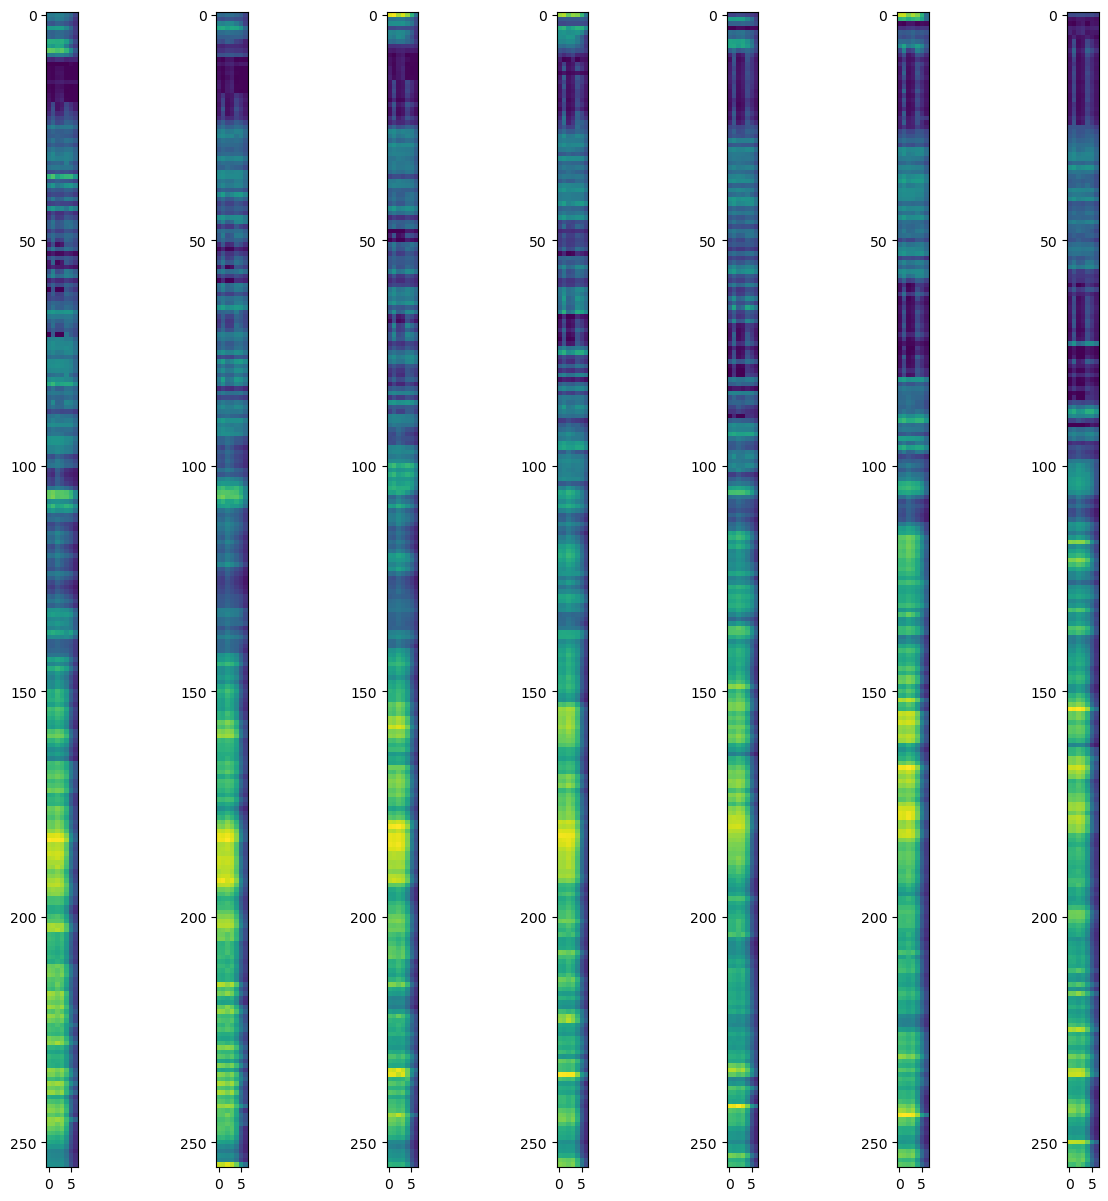

In [8]:
fig, axes = plt.subplots(1,7, figsize=(15,15))
for i, ax in enumerate(axes.flat):
    ax.imshow(img_tiff_merged[i])
    #ax.imshow(resized_img_tiff_merged[i])

In [9]:
feed = np.expand_dims(img_tiff_merged, axis=0)
print(feed,"\n", feed.shape)

[[[[ 4799  4717  5097 ...  4350  3867  2338]
   [ 4437  4295  4867 ...  4026  3284  1825]
   [ 3123  2991  3638 ...  2919  2353  1547]
   ...
   [ 5460  5339  5258 ...  4429  2515  1478]
   [ 5632  5551  5427 ...  4703  2582  1552]
   [ 5849  5796  5679 ...  4918  2813  1664]]

  [[ 4032  3884  4215 ...  3815  3449  2285]
   [ 2774  2690  2965 ...  2718  2746  1969]
   [ 5245  5066  5449 ...  4714  3848  2116]
   ...
   [ 5723  5642  5548 ...  4752  2750  1699]
   [ 5254  5197  5178 ...  4362  2299  1399]
   [10676 10514 11180 ...  9074  5970  4287]]

  [[11378 11670 10303 ...  9904  7588  4369]
   [ 4611  4544  4748 ...  4194  3866  2589]
   [ 5795  5870  5868 ...  5341  4563  2678]
   ...
   [ 6126  5981  5931 ...  5054  2667  1497]
   [ 6649  6476  6453 ...  5436  2921  1760]
   [ 7743  7570  7501 ...  6478  3523  2116]]

  ...

  [[ 1622  2149  1671 ...  2166  1635  1040]
   [ 1552  2220  1570 ...  2307  1870  1415]
   [ 1337  2264  1181 ...  2509  2053  1319]
   ...
   [ 7600  739

In [10]:
res = local_loaded_model.predict(feed)

1/1 [==============================] - 0s 174ms/step


In [11]:
res

array([[[[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        ...,

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [0.],
         [1.],
         [1.]]]], dtype=float32)

In [12]:
from matplotlib.colors import ListedColormap

# 1. == cloud
# 0 == else

unet_color_code = {1.0: "white", 0.0: "black"}
unet_cmap = ListedColormap([unet_color_code[i] for i in range(2)])

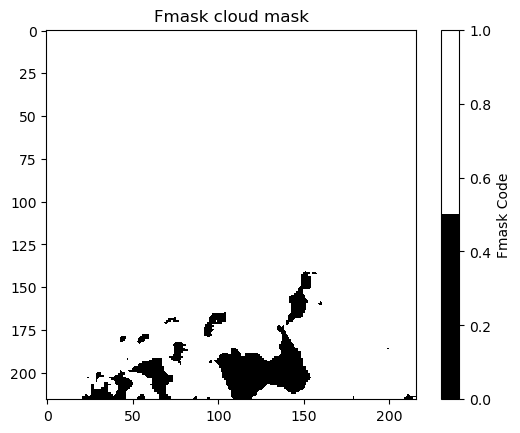

In [14]:
#fig, ax = plt.subplots(1,1, figsize=(10,10))

plt.imshow(res[0], cmap=unet_cmap)
plt.colorbar(label="Unet Code")
plt.title("Unet cloud mask")
plt.show()

In [92]:
def np_3D_array_to_tiff(output_path, np_array, projection, geo_transform, no_data_value=15):
    """
    Note: Filename has to end with .tiff (double f)
    """
    if output_path[-5:] != ".tiff":
        output_path += ".tiff"

    np_array[np.isnan(np_array)] = no_data_value

    driver = gdal.GetDriverByName("GTiff")
    out_raster = driver.Create(output_path, np_array.shape[2], np_array.shape[1], np_array.shape[0], gdal.GDT_Float32)
    # where np_array.shape(0) is band amount
    out_raster.SetProjection(projection)
    out_raster.SetGeoTransform(geo_transform)
    
    for i, b in enumerate(np_array):  # np_array has to be sorted (bands) in ascending order
        out_band = out_raster.GetRasterBand(i+1)  # Gdal Rasters start at index 1
        out_band.WriteArray(b)
        # out_band.SetNoDataValue(no_data_value)  # safe?
        out_band.FlushCache()
        out_band = None
    out_raster.FlushCache()
    out_raster = None

In [95]:
np_3D_array_to_tiff(modis_tower_path+day1+"_predicted256_mask", res[0], img_gdal_merged.GetProjection(), img_gdal_merged.GetGeoTransform())

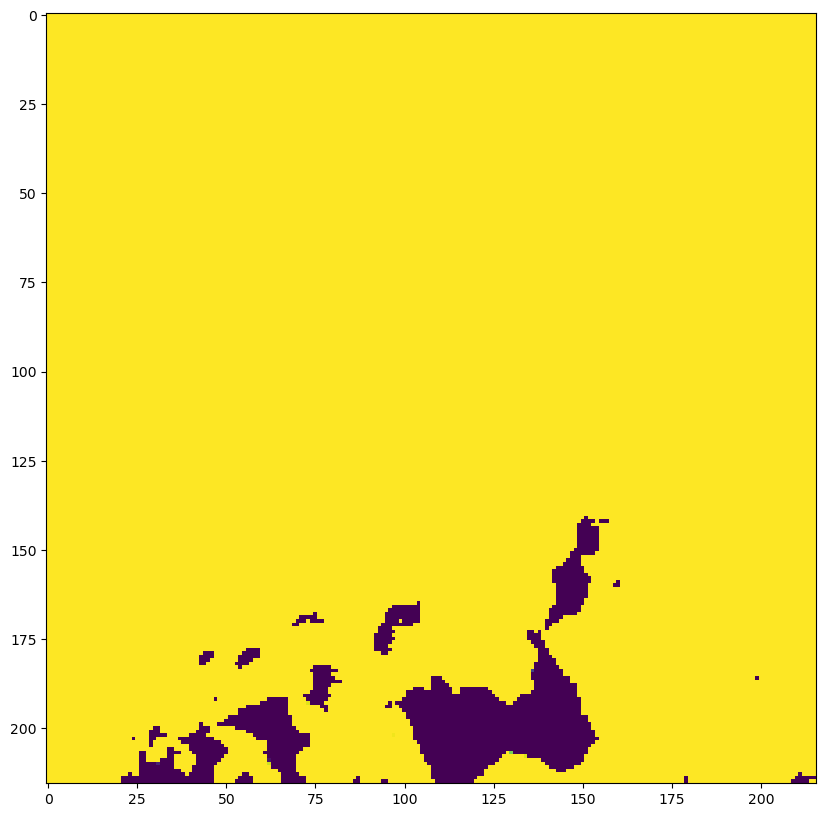

In [21]:
pred_mask = gdal.Open(modis_tower_path+day1+"_predicted256_mask.tiff").ReadAsArray()
fig, ax = plt.subplots(1,1, figsize=(10,10))

ax.imshow(pred_mask)

In [181]:
pred_mask

array([[2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0]], dtype=uint8)

In [5]:
from ..srcv2_2.utils import patch_image, stitch_image

ImportError: attempted relative import with no known parent package

In [12]:
def patch_mod(img, patch_size=256, overlap=10):
    """
    Input:
    img: Shape = (width, height, depth)   (Note: Gdal probably supplies (depth, width, height) )

    Plan:
    I need to buffer every patch, not only the whole image. Buffer around all 4 edges with actual image data (if possible),
    not white noise, as I dont want to lose the information and the algo/model probably works better with more information.

    For the model i need:
    Therefore cut_size+buffer == 256 has to hold, as i need 7x256x256 images.
    Do i need to scale up to 256x256 on the edge-images? Yes
    #buffer2 = max(buffer, current_patch_size - cut_size) 

    This will probably result in worse results on the edges.

    cut_size > buffer!
    """
    cut_size = patch_size - 2*overlap  # buffer around all edges

    if cut_size <= overlap:
        raise ValueError("overlap < cut_size False")


    img_shape = np.shape(img)

    # Find number of patches
    n_width = int(np.ceil(int(img_shape[0]) / cut_size))
    n_height = int(np.ceil(int(img_shape[1]) / cut_size))

    # find rest 
    bufferx = int(max(overlap, n_width*cut_size-int(img_shape[0])))
    buffery = int(max(overlap, n_height*cut_size-int(img_shape[1])))

    print("buffer(x): " ,bufferx, "buffer(y): ", buffery)

    # prepare padded img of zeros
    img_padded = np.zeros((overlap + int(img_shape[0]) + bufferx, overlap + int(img_shape[1]) + buffery, int(img_shape[2])), dtype=img.dtype)
    img_padded[overlap:overlap + int(img_shape[0]), overlap:overlap + int(img_shape[1]), :] = img
    
    #patches = [[None] * n_height] * n_width
    img_patched = np.zeros((n_height * n_width, patch_size, patch_size, int(img_shape[2])), dtype=img.dtype)


    # cut patches
    for i in range(n_width):
        for j in range(n_height):
            id = n_height * i + j

            # patches[i][j] = img[i*cut_size-buffer:(i+1)*cut_size+buffer, j*cut_size-buffer:(j+1)*cut_size+buffer, :]
            xfrom = i*cut_size - min(i*overlap, overlap)
            xto = (i+1)*cut_size + (overlap*2 if i == 0 else overlap)   #+min((i+1)*buffer, buffer*2) #min(i*cut_size, buffer)
            yfrom = j*cut_size - min(j*overlap, overlap)
            yto = (j+1)*cut_size + (overlap*2 if j == 0 else overlap) #cut_size+min((j+1)*buffer, buffer*2) # min(j*cut_size, buffer)
            #patches[i][j] = img_padded[xfrom:xto, yfrom:yto, :]# 0:7]

            # Cut out the patches.
            # img_patched[id, width , height, depth]
            img_patched[id, :, :, :] = img_padded[xfrom:xto, yfrom:yto, :] #patches[i][j] # img_padded[xmin:xmax, ymin:ymax, :]

    return img_patched, img_shape, img.dtype, n_width, n_height



In [13]:
wpd = tiff.imread(modis_tower_path+day1+"_merged_2400_wgs84_warped.tiff")

In [14]:
wpd.shape

(2064, 3211, 7)

In [15]:
img_patched, og_shape, og_dtype, n_width, n_height = patch_mod(img=wpd, overlap=0)

buffer(x):  240 buffer(y):  117


In [16]:
og_shape

(2064, 3211, 7)

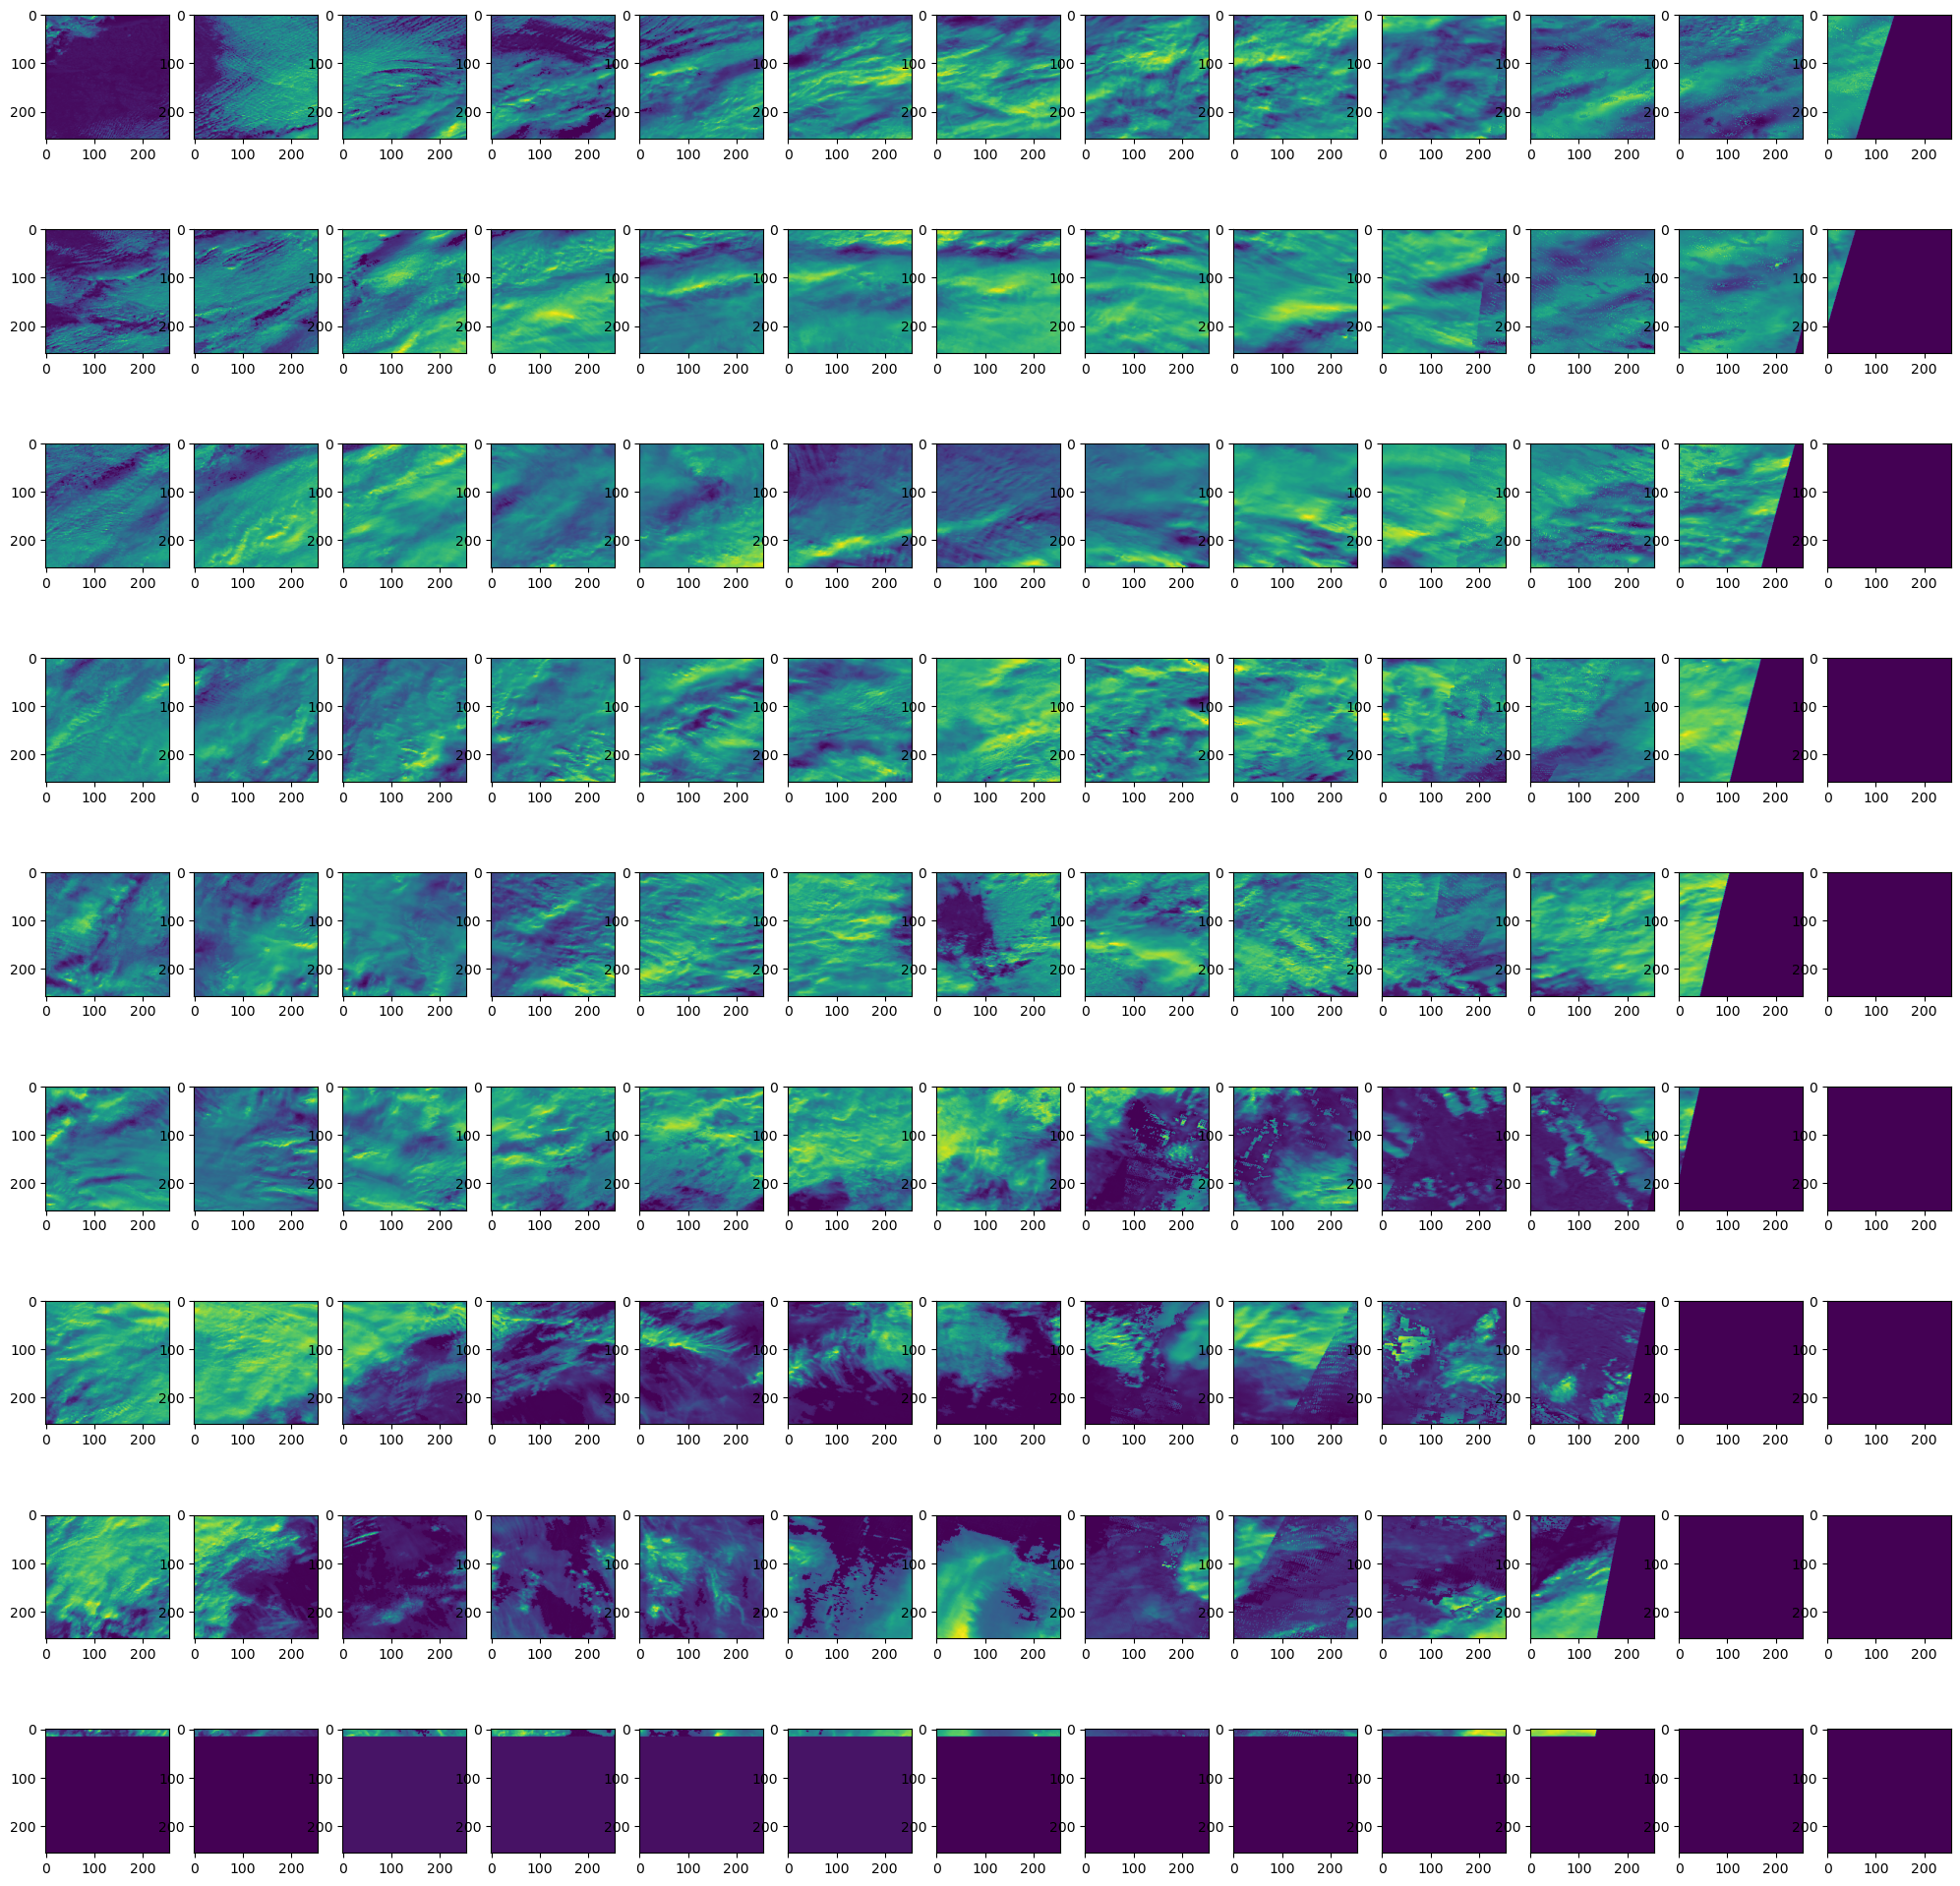

In [17]:
fig, axes = plt.subplots(n_width,n_height, figsize=(25,25))

for i, ax in enumerate(axes.flat):
    ax.imshow(img_patched[i][:,:,0])

In [18]:
def stitch_mod(images, og_shape, og_dtype, patch_size=256, overlap=10):
    """
    images: (index_img, width, height, depth)
    og_shape: (width, height, depth)
    """
    cut_size = patch_size - 2*overlap 
    
    # Find number of patches
    n_width = int(np.ceil(int(og_shape[0]) / cut_size))
    n_height = int(np.ceil(int(og_shape[1]) / cut_size))

    # find rest 
    bufferx = int(max(overlap, n_width*cut_size-int(og_shape[0])))
    buffery = int(max(overlap, n_height*cut_size-int(og_shape[1])))
    
    # define image with bufferx and buffery to fit all patches. buffers will be omitted later
    img_stitched = np.zeros((og_shape[0]+bufferx, og_shape[1]+buffery, og_shape[2]), dtype=og_dtype)

    #for i, img in enumerate(images):
    for i in range(n_width):
        for j in range(n_height):
            id = n_height * i + j
            img_temp = np.zeros((cut_size, cut_size, og_shape[2]), dtype=og_dtype)
            img_temp = images[id][overlap:patch_size-overlap, overlap:patch_size-overlap, :]
            img_stitched[i*cut_size:(i+1)*cut_size, j*cut_size:(j+1)*cut_size,:] = img_temp

    return img_stitched[0:og_shape[0],0:og_shape[1],:]
        



In [19]:
stitched_img = stitch_mod(img_patched, og_shape, og_dtype, overlap=0)

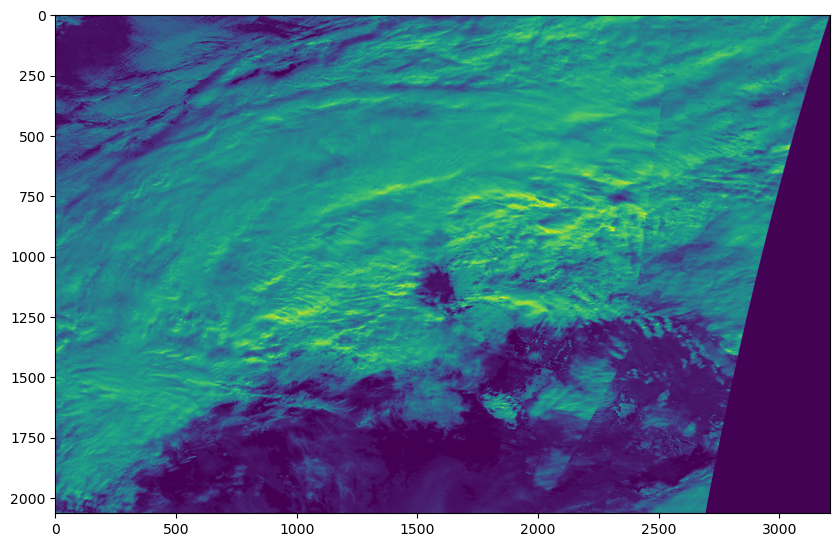

In [20]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(stitched_img[:,:,0])

In [21]:
from srcv2_2.utils import get_model_name, predict_img_mod

In [25]:
overlap=10

In [26]:

#params.n_cls=1

In [27]:
pred = predict_img_mod(unet_loaded_local_model, params, wpd, 
                       n_bands=7, 
                       n_cls=1, 
                       num_gpus=params.num_gpus,
                       ps_overlap=overlap)

4/4 [==============================] - 3s 864ms/step


i index 
1: predicted mask
2: predicted binary mask



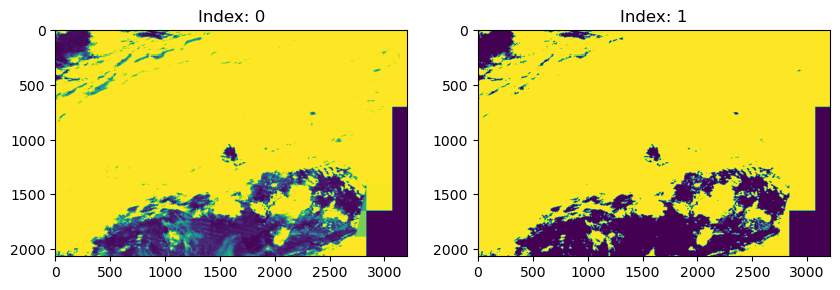

In [28]:
fig, axes = plt.subplots(1,2, figsize=(10,10))

print("""i index 
1: predicted mask
2: predicted binary mask
""")
for i , ax in enumerate(axes.flat):
    ax.set(title="Index: " + str(i))
    ax.imshow(pred[i][:,:,0])
    ax.plot()